# Vgg method



## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

### Small functions

In [2]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [3]:
DP_DIR = '../input/shuffle-csvs/'
INPUT_DIR = '../input/quickdraw-doodle-recognition/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

## Training with Image Generator

In [7]:
def draw(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_gene(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_img(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

### Building VGG model


In [5]:
STEPS = 800
#EPOCHS = 16
size = 64
batchsize = 680

In [6]:
vgg = VGG16( weights = "../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
            include_top=False,  input_shape=(size, size, 3) ,
            pooling='max', classes = NCATS)

for layer in vgg.layers[:17]:#adjustment
    layer.trainable = False

x = vgg.output
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(NCATS, activation="softmax")(x)

# creating the final model 
vgg_model = Model(inputs = vgg.input, outputs = predictions)

vgg_model.summary()

# variables will be used to train the model
batch_size = 150
epochs = 5


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

### Data preparation

In [8]:
from sklearn.model_selection import train_test_split
df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x = df_to_img(df, size)
x = np.dstack([x] * 3)
x = x.reshape (-1,size,size,3)
y = keras.utils.to_categorical(df.y, num_classes=NCATS)
print(x.shape, y.shape)
print('Validation array memory {:.2f} GB'.format(x.nbytes / 1024.**3 ))

(34000, 64, 64, 3) (34000, 340)
Validation array memory 1.56 GB


In [9]:
X_train = x[0:30000,:]
X_test = x[30000:,:]
y_train = y[0:30000,:]
y_test = y[30000:,:]

### Model training

In [10]:
# Training the model
batch_size = 150
epochs = 50
callbacks = [
    EarlyStopping(monitor= 'val_top_3_accuracy', patience=2),
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
#model = create_model()
hists = []
vgg_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = [categorical_crossentropy,categorical_accuracy, top_3_accuracy])
    
    
hist = vgg_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
validation_data=(X_test, y_test),
                    callbacks = callbacks)
hists.append(hist)

Train on 30000 samples, validate on 4000 samples
Epoch 1/50
30000/30000 [==============================] - 35s 1ms/step - loss: 4.5086 - categorical_crossentropy: 4.5086 - categorical_accuracy: 0.1058 - top_3_accuracy: 0.2132 - val_loss: 3.5222 - val_categorical_crossentropy: 3.5222 - val_categorical_accuracy: 0.2203 - val_top_3_accuracy: 0.3965
Epoch 2/50
30000/30000 [==============================] - 31s 1ms/step - loss: 3.2917 - categorical_crossentropy: 3.2917 - categorical_accuracy: 0.2561 - top_3_accuracy: 0.4443 - val_loss: 3.0986 - val_categorical_crossentropy: 3.0986 - val_categorical_accuracy: 0.2957 - val_top_3_accuracy: 0.4977
Epoch 3/50
30000/30000 [==============================] - 31s 1ms/step - loss: 2.8583 - categorical_crossentropy: 2.8583 - categorical_accuracy: 0.3301 - top_3_accuracy: 0.5386 - val_loss: 2.9273 - val_categorical_crossentropy: 2.9273 - val_categorical_accuracy: 0.3373 - val_top_3_accuracy: 0.5375
Epoch 4/50
30000/30000 [==============================

### Drawing loss and accuracy graphs

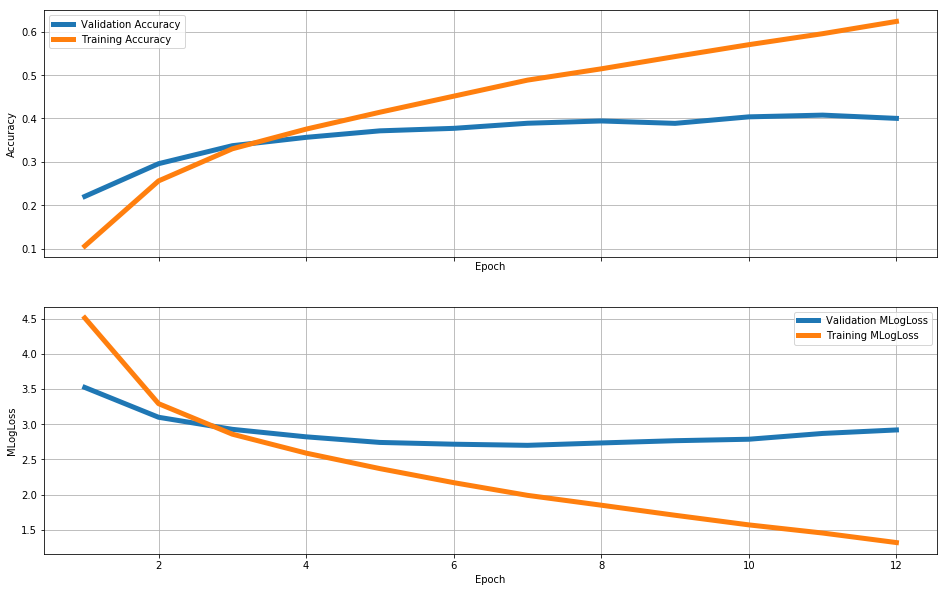

In [15]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

### Tesing

In [16]:
valid_predictions = vgg_model.predict(X_test, batch_size=150, verbose=1)
actual = df['y'][30000:].values
predicted = preds2catids(valid_predictions).values
test_acc = 0
for i in range(4000):
    if actual[i] in predicted[i]:
        test_acc += 1
test_acc = test_acc/4000
print(test_acc)

4000/4000 [==============================] - 3s 865us/step
0.599
